In [1]:
import torch
import math
import torch.nn.functional as F
from torchvision.datasets import MNIST

# data preprocessing

In [2]:
ds = MNIST('.',train = True, download= True)
val_ds = MNIST('.',train = False, download= True)

In [3]:
def normalize(x,m,s):
    return (x-m)/s

In [4]:
x = ds.data.reshape(60000,(28*28)).float()#/255. # it is not good to normalize images with 255
y = ds.targets

val_x = val_ds.data.reshape(val_ds.data.shape[0],(28*28)).float()#/255.
val_y = val_ds.targets

In [5]:
mean = x.mean()
std = x.std()
mean , std

(tensor(33.3184), tensor(78.5675))

In [6]:
x = normalize(x,mean,std) # it is a better way to normalize images with (x-mean) / std
val_x = normalize(val_x,mean,std)

In [7]:
x.mean(),x.std()

(tensor(1.8601e-08), tensor(1.))

In [8]:
n, m = x.shape
c = y.max()+1

In [9]:
n,m,c

(60000, 784, tensor(10))

# weight initialization

In [10]:
n_in = 28 *28
nh = 50
n_out = 1
bs = 64
lr = 0.01

In [11]:
# kaiming init / he init for relu, which can not maintain mean and std with other type of init
w1 = torch.randn(n_in,nh)* (2/m)**0.5 
b1 = torch.zeros(nh)
w2 = torch.randn(nh,n_out)* (2/m)**0.5 
b2 = torch.zeros(1)

# Function based NN

In [12]:
def lin(x, w, b):
    return x @ w + b

In [13]:
def relu(x):
    return x.clamp_min(0).float()

In [14]:
def mse(pred, y):
    return ((pred.squeeze(-1)-y)**2).float().mean()

In [15]:
#Al 
def mse_grad(pred, y):
    pred.g = 2. * (pred.squeeze() - y).unsqueeze(-1) / y.shape[0]

In [16]:
def relu_grad(Z, A):
    Z.g = (Z > 0).float() * A.g

In [17]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [18]:
def opt(lr,w,b):
    w -= w.g*lr
    b -= b.g*lr

In [19]:
def forward_backward(x, y, w1, b1, w2, b2):
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    
    loss = mse(out, y)
    
    mse_grad(out ,y)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(x, l1, w1, b1)
    opt(0.01,w2,b2)
    opt(0.01,w1,b1)
    print(f'loss: {loss}')

In [20]:
for i in range(3):
    forward_backward(x,y,w1,b1,w2,b2)

loss: 27.614992141723633
loss: 11.903169631958008
loss: 8.631827354431152


In [21]:
lin( relu(lin(x[8],w1,b1)) ,w2,b2)

tensor([2.1395])

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

(<matplotlib.image.AxesImage at 0x7f7c1c12c070>, tensor(1))

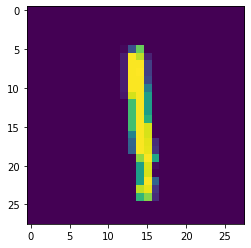

In [23]:
plt.imshow(x[8].view(28,28)),y[8]

# Class based NN

In [24]:
class Module:
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
        
    def forward(self):
        raise Exception('not implemented')
    def bwd(self):
        raise Exception('not implemented')
        
    def backward(self):
        self.bwd(self.out,*self.args)

In [25]:
class Relu(Module):
    def forward(self,x):
        return x.clamp_min(0.)-0.5
    def bwd(self, out, x):
        x.g = (x > 0).float()*out.g
    

In [26]:
class Lin(Module):
    def __init__(self,w,b):
        self.w = w
        self.b = b
    
    def forward(self, x):
        return ( x @ self.w ) + self.b
    
    def bwd(self,out ,x):
        x.g = out.g @ self.w.T
        self.w.g = x.T @ out.g
        self.b.g = out.g.sum(0)

In [27]:
class Mse(Module):
    def forward(self,pred,y):
        return ((pred.squeeze() -y )**2).mean()
    def bwd(self,out, pred , y):
        pred.g = 2*(pred.squeeze() - y ).unsqueeze(-1)/y.shape[0]
        

In [28]:
class Model:
    def __init__(self,w1,b1,w2,b2):
        self.layers = [Lin(w1,b1),Relu(),Lin(w2,b2)]
        self.loss = Mse()
    def __call__(self,x,y):
        for l in self.layers:
            x = l(x)
        return self.loss(x,y)
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [29]:
model = Model(w1,b1,w2,b2)

In [30]:
loss = model(x,y)

In [31]:
model.backward()

# Pytorch NN

In [32]:
import torch.nn as nn

In [33]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [34]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [35]:
model =Model(n_in,nh,n_out)

In [36]:
loss = model(x,y)

In [37]:
loss.backward()

In [38]:
loss

tensor(31.2564, grad_fn=<MeanBackward0>)

# day 9 How to train your model 

In [39]:
nn.modules.conv._ConvNd.reset_parameters??

In [40]:
# x= x.view(-1,1,28,28)

In [41]:
x.shape

torch.Size([60000, 784])

In [42]:
def stats(x): return x.mean(),x.std()

In [43]:
l1 = nn.Conv2d(1, 32, 5)

In [44]:
stats(l1.weight)

(tensor(-0.0008, grad_fn=<MeanBackward0>),
 tensor(0.1163, grad_fn=<StdBackward0>))

In [45]:
def gain(a):
    return math.sqrt(2.0 /(1 + a**2))

In [46]:
gain(5**0.5)

0.5773502691896257

In [47]:
def kaiming2(x, a, use_fan_out=False):
    nf, ni, *_ = x.shape
    rec_fs = x[0,0].shape.numel()
    fan = nf*rec_fs if use_fan_out else ni*rec_fs
    std = gain(a) /math.sqrt(fan)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound,bound)

In [48]:
kaiming2(l1.weight,a=0)
stats(x)

(tensor(1.8601e-08), tensor(1.))

# cross entropy loss

In [49]:
def log_softmax1(x):
    return (x.exp()/x.exp().sum(-1,keepdims= True)).log()

In [50]:
def log_softmax2(x):
    return x - x.exp().sum(-1, keepdims= True).log()

In [51]:
log_softmax1(torch.arange(5)),log_softmax2(torch.arange(5)) # same  b/c: log(a/b) == log(a) - log(b) & ln(e^x)==x

(tensor([-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]),
 tensor([-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]))

In [52]:
def nll(perd , y):
    return - pred[range(y.shape[0]), y].mean()

In [53]:
def logsumexp(x):
    m = x.max(-1)[0]
    print(x.shape,m.shape)
    return m + (x - m[:,None]).exp().sum(-1).log()

In [54]:
def log_softmax(x): # now it is stable then previous two version
    return x - logsumexp(x)

In [55]:
m = nn.Sequential(nn.Linear(28*28,256),nn.ReLU(),
                  nn.Linear(256,64),nn.ReLU(),
                  nn.Linear(64,10) )


In [56]:
out = m(x)

In [57]:
pred = log_softmax1(out)

In [58]:
pred.shape,y.shape

(torch.Size([60000, 10]), torch.Size([60000]))

In [59]:
nll(pred,y)

tensor(2.3163, grad_fn=<NegBackward0>)


# Training loop and dataloader

In [60]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(n_in,nh,),nn.ReLU(),nn.Linear(nh,n_out)])
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x

In [61]:
def accuracy(pred, y):
    return (torch.argmax(pred, dim=1)  ==y).float().mean()

In [62]:
class Dataset:
    def __init__(self,x,y): self.x,self.y = x,y
        
    def __len__(self): return len(self.y)
    
    def __getitem__(self,i): return self.x[i] ,self.y[i]

In [63]:
class DataLoader:
    def __init__(self, ds, bs): self.bs, self.ds = bs , ds
    def __iter__(self):
        bs = self.bs
        for i in range(0,len(self.ds),bs): yield self.ds[i:i+bs]

In [64]:
class Sampler:
    def __init__(self,ds,bs,shuffle = True):
        print(len(ds))
        self.m, self.bs, self.shuffle = len(ds),bs,shuffle
    def __iter__(self):
        
        idx = torch.randperm(self.m) if self.shuffle else torch.arange(self.m)
        print(len(idx),self.m)
        for i in (0, self.m, self.bs): yield idx[i:i+self.bs]

In [65]:
class Optimizer:
    def __init__(self,params,lr):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params : p.grad.data.zero_()

In [66]:
dl = DataLoader(ds,64)

In [67]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)
class Dataloader:
    def __init(self, ds,sampler,collate_fn= collate):
        self.ds , self,sampler, self.collate_fn = ds, sampler, collate_fn
    def __iter__(self):
        for s in sampler : yield self.collate_fn([ds[i] for i in s])

In [68]:
def get_dls(train_ds,val_ds,bs,**kwargs):
    return (DataLoader(train_ds,batch_size=bs,shuffle=True,**kwargs), #sampler = RandomSampler(ds), collate_fn=collate)
            DataLoader(val_ds,batch_size=bs*2,**kwargs) ) #sampler=SequentialSampler(val_ds),collate_fn=collate)

class DataBunch:
    def __init__(self, dl, val_dl, c=None):
        self.dl, self.val_dl, self.c = dl, val_dl, c
    @property
    def train_ds(self):
        return self.dl.dataset
    @property
    def val_ds(self):
        return self.val_dl.dataset

In [69]:
def get_model(data,lr=0.1,nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(),lr=lr)

class Learner:
    def __init__(self,model, opt, loss_fn, data):
        self.model,self.opt,self.loss_fn,self.data = model, opt, loss_fn,data

# Required data params

In [70]:
import torch.optim as optim
from torch.utils.data import SequentialSampler, RandomSampler, DataLoader

In [71]:
loss_fn = F.cross_entropy # F.crossentropy(pred,y) == nll(log_softmax(x),y)
ds = Dataset(x,y)
val_ds = Dataset(val_x,val_y)
data = DataBunch(*get_dls(ds,val_ds,bs),10)

In [72]:
model, opt = get_model(data)
learn = Learner(model,opt,loss_fn,data)

In [73]:
def fit(epochs,learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.dl:
            loss = learn.loss_fn(model(xb),yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval()  
        with torch.no_grad():
            tot_loss, tot_acc = 0.,0.
            for val_xb,val_yb in learn.data.val_dl:
                pred = learn.model(val_xb)
                tot_loss += learn.loss_fn(pred ,val_yb)
                tot_acc  += accuracy(pred,val_yb)
        nv = len(learn.data.val_dl)    
        print(f'epoch {epoch}: loss {tot_loss/nv}, accuarcy {tot_acc/nv}')
    return tot_loss/nv

In [74]:
fit(5,learn)

epoch 0: loss 0.15791253745555878, accuarcy 0.9505537748336792
epoch 1: loss 0.1205451488494873, accuarcy 0.9609375
epoch 2: loss 0.10280406475067139, accuarcy 0.9684533476829529
epoch 3: loss 0.10550582408905029, accuarcy 0.9659810066223145
epoch 4: loss 0.0965634360909462, accuarcy 0.9698378443717957


tensor(0.0966)

# Callback

In [75]:
import re

In [76]:
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1,r'\1_\2',name)
    return re.sub(_camel_re2,r'\1_\2',name).lower()

class Callback:
    _order = 0 
    def set_runner(self,run):self.run = run
    def __getattr__(self,k): return getattr(self.run ,k)
    @property
    def name(self):
        name = re.sub(r'Callback$','',self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [77]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_iter = 0
        self.run.n_epochs = 0
    def after_batch(self):
        if not self.in_train : return 
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False

In [78]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters > 10 : return True

In [79]:
from typing import *

In [80]:
def listify(o):
    if o is None  : return []
    if isinstance(o,list): return o
    if isinstance(o,str) : return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [81]:
class Runner:
    def __init__(self,cbs=None, cb_func= None):
        cbs = listify(cbs)
        for cbf in listify(cb_func):
            cb = cbf()
            setattr(self,cb.name,cb)
            cbs.append(cb)
        self.stop,self.cbs = False, [TrainEvalCallback()]+cbs
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_fn
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self,xb,yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'):return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred , self.yb)
        if self('after_loss') or not self.in_train: return 
        self.loss.backward()
        if self('after_backward'):return
        self.opt.step()
        if self('after_step'): return 
        self.opt.zero_grad()
    
    def all_batches(self,dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop : break
            self.one_batch(xb,yb)
            self('after_batch')
        self.stop = False
            
    
    def fit(self,epochs,learn):
        self.epochs, self.learn = epochs, learn
        try: 
            for cb in self.cbs : cb.set_runner(self)
            if self('begin_fit'): return 
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.dl)
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.val_dl)
                if self('after_epoch'):break
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self,cb_name):
        for cb in sorted(self.cbs, key = lambda x: x._order):
            f = getattr(cb,cb_name,None)
            if f and f(): return True
        return False
    

In [82]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [83]:
learn = Learner(*get_model(data), loss_fn, data)

In [84]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [85]:
run.fit(2, learn)

train: [0.2828158854166667, tensor(0.9172)]
valid: [0.18404368896484374, tensor(0.9425)]
train: [0.1375025390625, tensor(0.9587)]
valid: [0.126339013671875, tensor(0.9607)]


In [86]:
loss,acc = stats.valid_stats.avg_stats
assert acc>0.9
loss,acc

(0.126339013671875, tensor(0.9607))

# Annealing

In [87]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self) : plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self,pname,sched_func): self.pname , self.sched_func = pname, sched_func
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_param()
    

In [88]:
from functools import partial

In [89]:
def sched_lin(start ,end):
    def _inner(start,end,pos): return start+pos*(end-start)
    return partial(_inner,start,end)

In [90]:
def annealer(f):
    def _inner(start,end):return partial(f,start,end)
    return _inner
@annealer
def sched_lin(start,end,pos):
    return start + pos *(end-start)

In [91]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

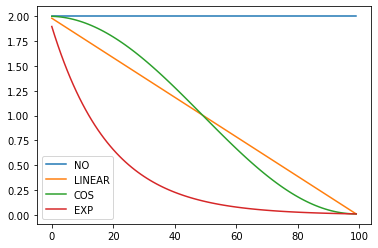

In [92]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [93]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [94]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [95]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [96]:
class ProgressShowingCallback(Callback):
    def __init__(self, exclamation="Awesome"): self.exclamation = exclamation
    def __call__(self, epoch): print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [97]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [98]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [99]:
learn = create_learner(get_model_func(0.3), loss_fn, data)
run = Runner(cb_func=cbfs)

In [100]:
run.fit(3, learn)

train: [0.31748811848958336, tensor(0.9056)]
valid: [0.38266201171875, tensor(0.8943)]
train: [0.1812466796875, tensor(0.9495)]
valid: [0.18052572021484375, tensor(0.9499)]
train: [0.09300760091145834, tensor(0.9726)]
valid: [0.10865113525390625, tensor(0.9721)]


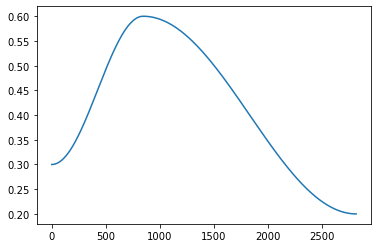

In [101]:
run.recorder.plot_lr()

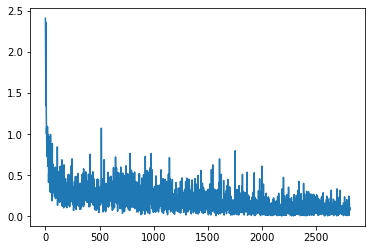

In [102]:
run.recorder.plot_loss()

# day 10 

In [103]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [104]:
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [105]:
class Runner:
    def __init__(self,cbs=None, cb_func= None):
        cbs = listify(cbs)
        for cbf in listify(cb_func):
            cb = cbf()
            setattr(self,cb.name,cb)
            cbs.append(cb)
        self.stop,self.cbs = False, [TrainEvalCallback()]+cbs
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_fn
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self,xb,yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'):return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred , self.yb)
        if self('after_loss') or not self.in_train: return 
        self.loss.backward()
        if self('after_backward'):return
        self.opt.step()
        if self('after_step'): return 
        self.opt.zero_grad()
    
    def all_batches(self,dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop : break
            self.one_batch(xb,yb)
            self('after_batch')
        self.stop = False
            
    
    def fit(self,epochs,learn):
        self.epochs, self.learn = epochs, learn
        try: 
            for cb in self.cbs : cb.set_runner(self)
            if self('begin_fit'): return 
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.dl)
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.val_dl)
                if self('after_epoch'):break
        except CancelTrainException: self('after_cancel_epoch')
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self,cb_name):
        for cb in sorted(self.cbs, key = lambda x: x._order):
            f = getattr(cb,cb_name,None)
            if f and f(): return True
        return False
    

In [106]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [107]:
run = Runner(cb_func=TestCallback)

In [108]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


In [109]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [110]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [111]:
learn = create_learner(get_model, loss_fn, data)

In [112]:
run = Runner(cb_func=[LR_Find, Recorder])

In [113]:
run.fit(2, learn)

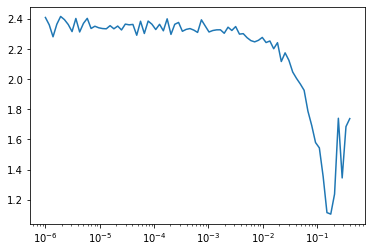

In [114]:
run.recorder.plot(skip_last=5)

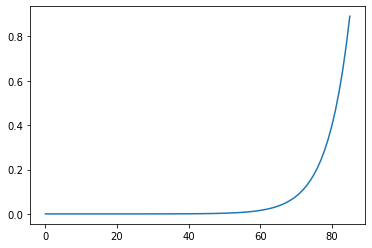

In [115]:
run.recorder.plot_lr()

In [116]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [117]:
x.mean(),x.std()

(tensor(1.8601e-08), tensor(1.))

# ConvNet

In [118]:
nh,bs = 50,512
c = y.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(ds, val_ds, bs), c)

In [119]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [120]:
def flatten(x):      return x.view(x.shape[0], -1)

In [121]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [122]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [123]:
model = get_cnn_model(data)

In [124]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [125]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_fn, data)
run = Runner(cb_func=cbfs)

In [126]:
%time run.fit(1, learn)

train: [1.6472342447916666, tensor(0.4493)]
valid: [1.10836982421875, tensor(0.6913)]
CPU times: user 13.4 s, sys: 10.6 ms, total: 13.4 s
Wall time: 7.35 s


# Cuda

In [127]:
# device = torch.device('cuda',0)

In [128]:
# class CudaCallback(Callback):
#     def __init__(self,device): self.device=device
#     def begin_fit(self): self.model.to(self.device)
#     def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [129]:
# Somewhat less flexible, but quite convenient
# torch.cuda.set_device(device)

In [130]:
# #export
# class CudaCallback(Callback):
#     def begin_fit(self): self.model.cuda()
#     def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [131]:
# cbfs.append(CudaCallback)

In [132]:
# run = Runner(cb_func=cbfs)

In [133]:
# %time run.fit(3, learn)

In [134]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [135]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [136]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [137]:
nfs = [8,16,32,32]

In [138]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [139]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_func=listify(cbs))

In [140]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [141]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [142]:
run.fit(3, learn)

train: [1.6695252604166666, tensor(0.4313)]
valid: [0.475084326171875, tensor(0.8383)]
train: [0.2823942057291667, tensor(0.9141)]
valid: [0.20180780029296874, tensor(0.9401)]
train: [0.14421564127604167, tensor(0.9560)]
valid: [0.2659074462890625, tensor(0.9196)]


In [143]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [144]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [145]:
run.fit(2, learn)

train: [1.33661328125, tensor(0.5343)]
valid: [0.34913720703125, tensor(0.8869)]
train: [0.247555029296875, tensor(0.9221)]
valid: [0.298144384765625, tensor(0.9087)]


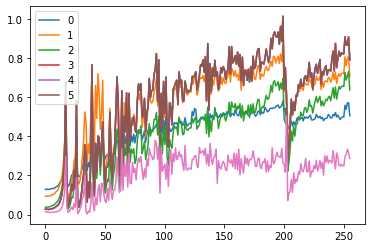

In [146]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

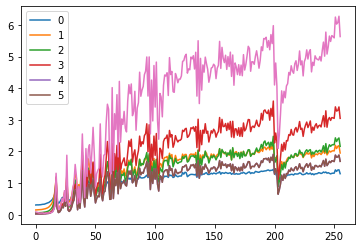

In [147]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

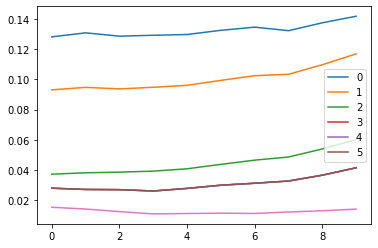

In [148]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

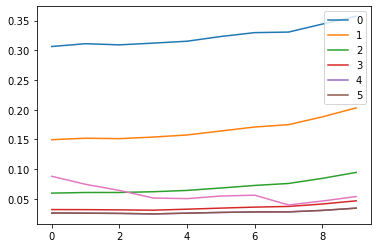

In [149]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

# Pytorch hook

In [150]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [151]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [152]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [153]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [154]:
run.fit(1, learn)

train: [1.9810313802083332, tensor(0.3052)]
valid: [0.7403501953125, tensor(0.7367)]


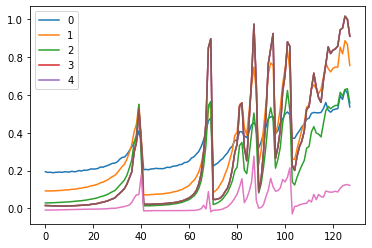

In [155]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook class

In [156]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [157]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [158]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [159]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [160]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f7c1ca41070>, <__main__.Hook object at 0x7f7c1ca41ee0>, <__main__.Hook object at 0x7f7c1ca41dc0>, <__main__.Hook object at 0x7f7c1ccbefa0>, <__main__.Hook object at 0x7f7c1ccbe2e0>, <__main__.Hook object at 0x7f7c1ccbe280>, <__main__.Hook object at 0x7f7c1ccbe340>]

In [161]:
hooks.remove()

In [162]:
x,y = next(iter(data.dl))
x = mnist_resize(x)

In [163]:
x.mean(),x.std()

(tensor(-0.0087), tensor(0.9908))

In [164]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2286, grad_fn=<MeanBackward0>),
 tensor(0.3933, grad_fn=<StdBackward0>))

In [165]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [166]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3722, grad_fn=<MeanBackward0>),
 tensor(0.6343, grad_fn=<StdBackward0>))

train: [1.9566912760416666, tensor(0.3279)]
valid: [1.5590458984375, tensor(0.4856)]
train: [0.5507039713541667, tensor(0.8302)]
valid: [0.20399937744140625, tensor(0.9355)]


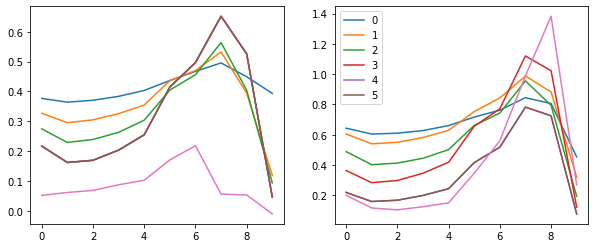

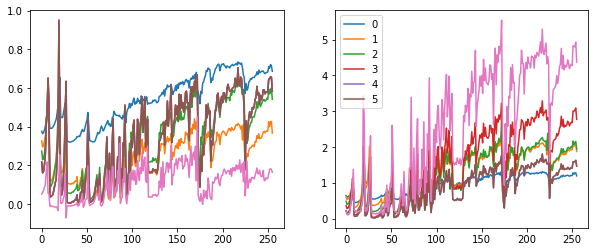

In [167]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [168]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [169]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [170]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [171]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.59122265625, tensor(0.4839)]
valid: [0.459414306640625, tensor(0.8593)]


In [172]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

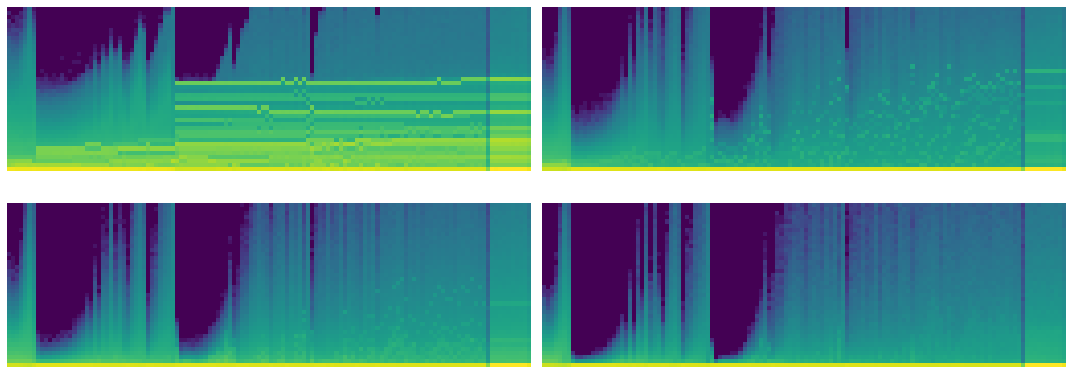

In [173]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [174]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

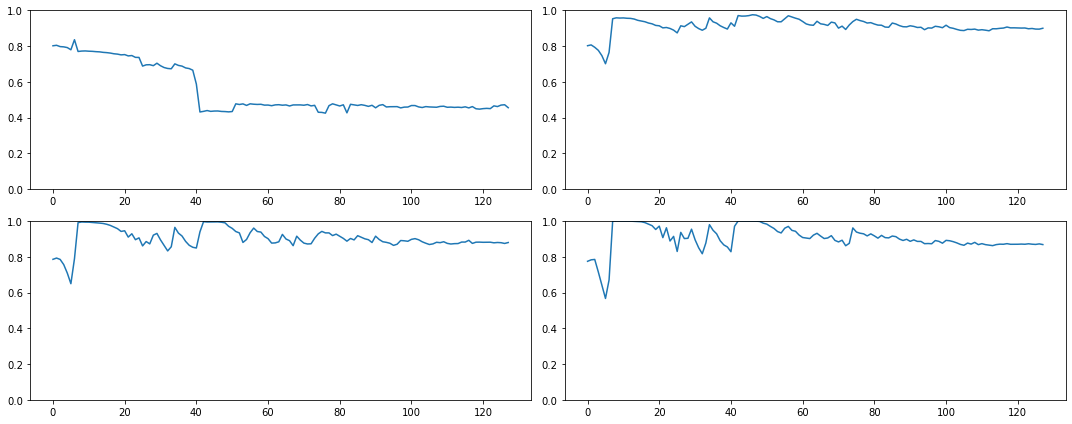

In [175]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Generalize Relu

In [176]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [177]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [178]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.45466686197916667, tensor(0.8555)]
valid: [0.16973232421875, tensor(0.9461)]


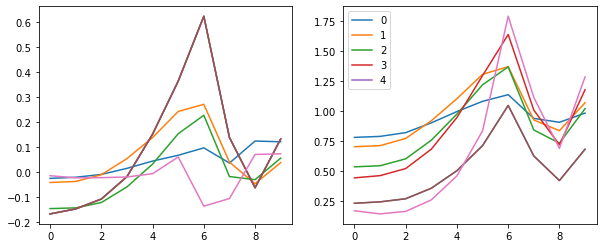

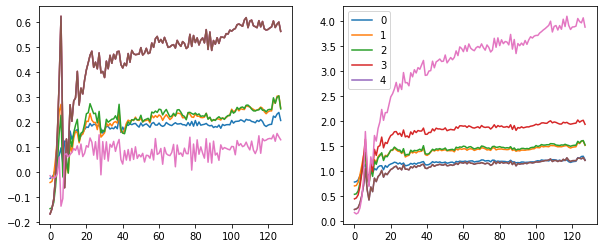

In [179]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

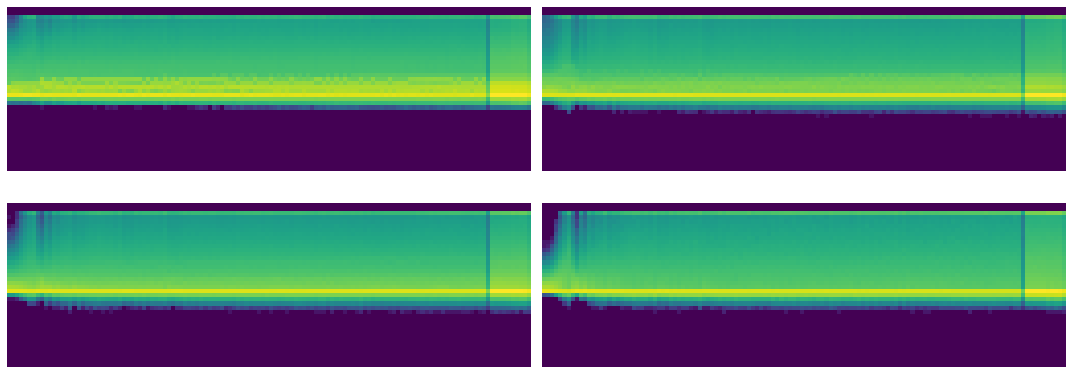

In [180]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [181]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

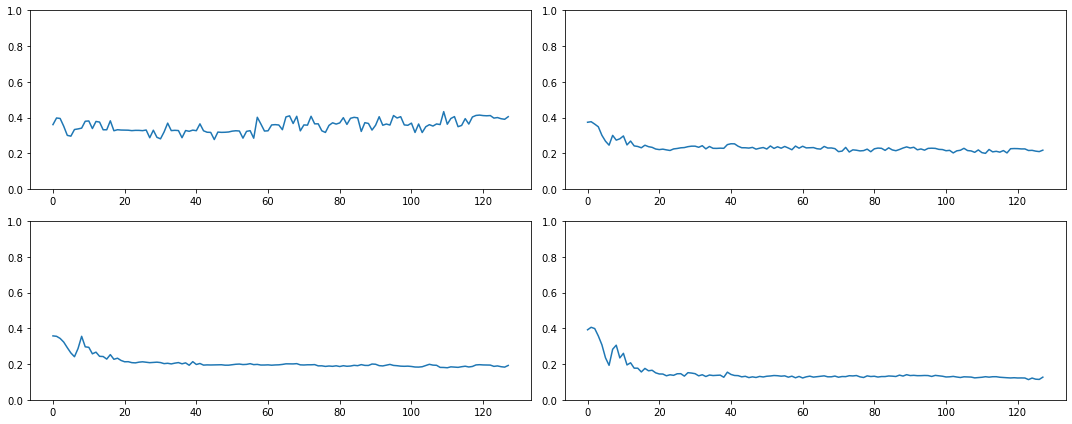

In [182]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [183]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [184]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [185]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [186]:
run.fit(8, learn)

train: [0.9582955729166667, tensor(0.7001)]
valid: [0.3136673095703125, tensor(0.9042)]
train: [0.2909356119791667, tensor(0.9129)]
valid: [0.20460784912109375, tensor(0.9394)]
train: [0.586188671875, tensor(0.8213)]
valid: [0.2894516845703125, tensor(0.9148)]
train: [0.14258513997395833, tensor(0.9570)]
valid: [0.18567724609375, tensor(0.9410)]
train: [0.0926791015625, tensor(0.9718)]
valid: [0.08758228759765625, tensor(0.9715)]
train: [0.05952272542317708, tensor(0.9816)]
valid: [0.0803660400390625, tensor(0.9743)]
train: [0.04439540201822917, tensor(0.9866)]
valid: [0.0574025390625, tensor(0.9825)]
train: [0.03714745686848958, tensor(0.9890)]
valid: [0.04630510864257813, tensor(0.9850)]


In [187]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [188]:
run.fit(8, learn)

train: [0.9970600260416667, tensor(0.6802)]
valid: [0.340859765625, tensor(0.8974)]
train: [0.2691654459635417, tensor(0.9184)]
valid: [0.645077685546875, tensor(0.8249)]
train: [0.23701306966145833, tensor(0.9297)]
valid: [0.3830816162109375, tensor(0.8841)]
train: [0.2534184244791667, tensor(0.9221)]
valid: [0.143344775390625, tensor(0.9568)]
train: [0.08669656575520833, tensor(0.9733)]
valid: [0.07567620239257812, tensor(0.9764)]
train: [0.06268134765625, tensor(0.9802)]
valid: [0.05827353515625, tensor(0.9826)]
train: [0.0478498291015625, tensor(0.9849)]
valid: [0.06133283081054688, tensor(0.9797)]
train: [0.04024952392578125, tensor(0.9876)]
valid: [0.0523080322265625, tensor(0.9838)]
